<a href="https://colab.research.google.com/github/IsaacFigNewton/CSC-480/blob/main/Roomba_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Config

In [1]:
contents = """
7
5
_#a____
___#__#
*__#_*_
_______
____*__
"""

In [12]:
import json
def show_world():
  for row in world["grid"]:
    print(row)

# Load the world file and its contents

In [ ]:
# from google.colab import files

# uploaded = files.upload()
# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

#   # To read the content of the file
#   with open(fn, 'r') as f:
#       contents = f.read()
#       print("\nFile contents:\n")

In [11]:
import json
print(json.dumps(world, indent=4))

{
    "cols": 7,
    "rows": 5,
    "grid": [
        "_#a____",
        "___#__#",
        "*__#_*_",
        "_______",
        "____*__"
    ]
}


# Construct a world graph

## Helpers

In [32]:
import networkx as nx

def build_world_graph(file_contents:str) -> nx.Graph:
  # TODO: remove the offset for world_lst when moving this to the python file
  world_lst = contents.split("\n")[1:]
  world = {
      "cols": int(world_lst[0]),
      "rows": int(world_lst[1]),
      "grid": world_lst[2:-1]
  }

  # make a grid graph of the same dims as the input world's file
  g = nx.grid_2d_graph(world["rows"], world["cols"])
  # label each node with the corresponding char from the input text
  nx.set_node_attributes(
      g,
      {
        n: {
          "type": world["grid"][n[0]][n[1]]
        } for n in g.nodes
      }
  )
  return g


def draw_world(g: nx.Graph, pos):
  nx.draw(
    g,
    pos=pos
  )
  nx.draw_networkx_labels(
      g,
      pos=pos,
      labels={n: g.nodes[n]["type"] for n in g.nodes}
  )

## Main

In [34]:
G = build_world_graph(contents)

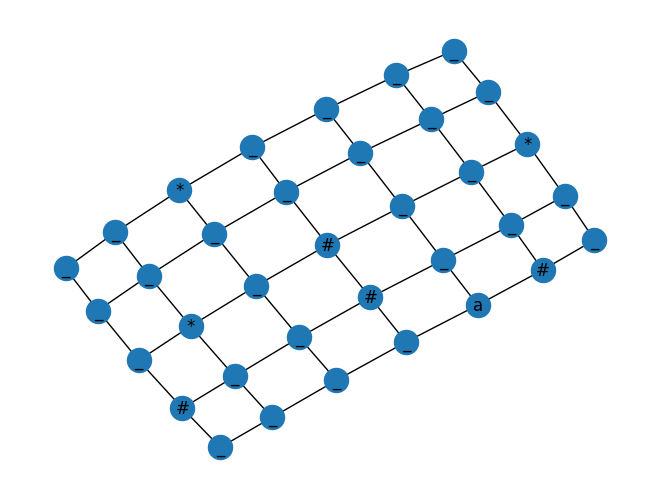

In [35]:
# set the label and node positions so graph looks the same each iteration
pos = nx.spring_layout(G)

draw_world(G, pos)